In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

#### Hyperparameters

In [2]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

train_dataset = "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv"
eval_dataset  = "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv"

#### Reading and Decoding

In [3]:
def read_and_decode(filename, reshape_dims):
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  img = tf.image.convert_image_dtype(img, dtype=tf.float32)
  return tf.image.resize(img, reshape_dims)

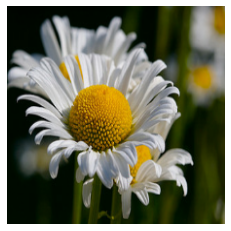

In [4]:
def show_image(filename):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  plt.imshow(img.numpy())
  plt.axis("off")

show_image("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

#### Getting the class names

In [5]:
file = tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*")
items = tf.strings.regex_replace(file, "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")

CLASS_NAMES = [item.numpy().decode('utf-8') for item in items]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
CLASS_NAMES

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

#### Printing all the flowers

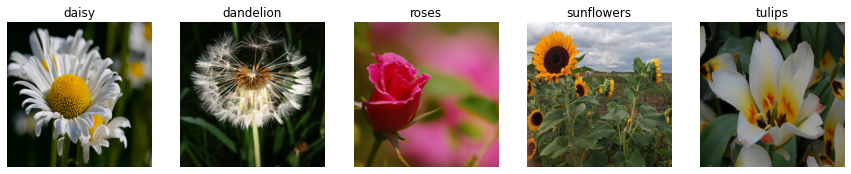

In [6]:
f, ax = plt.subplots(1, 5, figsize=(15, 15))

for idx, filename in enumerate([
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713398906_28e59a225a_n.jpg"]):

  img = read_and_decode(filename=filename, reshape_dims=[IMG_HEIGHT, IMG_WIDTH])
  ax[idx].set_title(CLASS_NAMES[idx])
  ax[idx].imshow(img)
  ax[idx].axis("off")

### Reading the csv dataset

In [7]:
def decode_csv(csv_row):
  record_defaults = ['path', 'flower']
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  return img, label_string

In [8]:
dataset = tf.data.TextLineDataset("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").map(decode_csv)

for img, label in dataset.take(5):
  avg = tf.math.reduce_mean(img, axis=[0,1])
  print("{:10}|{}".format(label.numpy().decode('utf-8'), avg.numpy()))

daisy     |[0.3588961  0.36257887 0.26933077]
dandelion |[0.32278517 0.32278517 0.32278517]
dandelion |[0.20397592 0.13298093 0.07217225]
dandelion |[0.24385852 0.25810573 0.18514276]
daisy     |[0.44251883 0.42566806 0.32949686]


#### Linear model 

In [9]:
def parse_csv(csv_row):
  record_defaults = ['path', 'flower']
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])  
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label  

In [10]:
train_dataset = tf.data.TextLineDataset(train_dataset).map(parse_csv).batch(10)
eval_dataset = tf.data.TextLineDataset(eval_dataset).map(parse_csv).batch(10)

In [11]:
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(
                                 input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
                             ), 
                             tf.keras.layers.Dense(
                                 units=len(CLASS_NAMES),
                                 activation='softmax'                                 
                             )                            
])

In [12]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


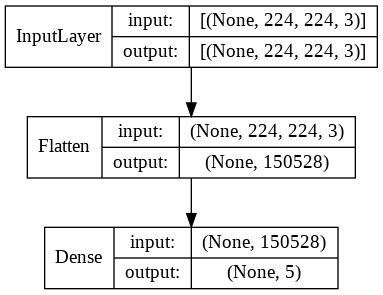

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [15]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
330/330 [==============================] - 149s 444ms/step - loss: 15.9095 - accuracy: 0.3391 - val_loss: 10.1330 - val_accuracy: 0.4459
Epoch 2/10
330/330 [==============================] - 130s 394ms/step - loss: 13.8475 - accuracy: 0.4227 - val_loss: 32.8667 - val_accuracy: 0.3811
Epoch 3/10
330/330 [==============================] - 112s 338ms/step - loss: 17.2436 - accuracy: 0.4288 - val_loss: 19.0746 - val_accuracy: 0.4108
Epoch 4/10
330/330 [==============================] - 106s 321ms/step - loss: 15.0216 - accuracy: 0.4691 - val_loss: 27.4323 - val_accuracy: 0.3946
Epoch 5/10
330/330 [==============================] - 105s 318ms/step - loss: 12.8436 - accuracy: 0.5118 - val_loss: 26.6425 - val_accuracy: 0.3568
Epoch 6/10
330/330 [==============================] - 104s 314ms/step - loss: 13.6148 - accuracy: 0.5191 - val_loss: 27.5989 - val_accuracy: 0.4027
Epoch 7/10
330/330 [==============================] - 102s 308ms/step - loss: 11.4589 - accuracy: 0.5497 - val_l

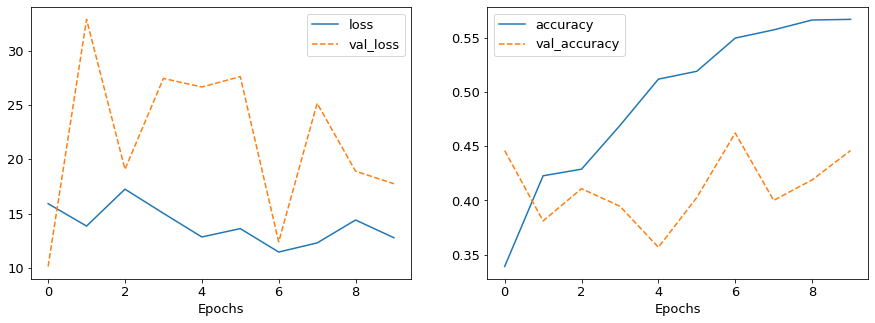

In [125]:
import matplotlib
def training_plot(metrics, history):
  matplotlib.rcParams.update({'font.size':13})
  f, ax = plt.subplots(1, len(metrics), figsize=(15, 5))

  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], label=metric)
    ax[idx].plot(history.history['val_'+metric], label='val_'+metric, ls='dashed')    
    ax[idx].set_xlabel('Epochs')    
    ax[idx].legend()

training_plot(['loss', 'accuracy'], history)

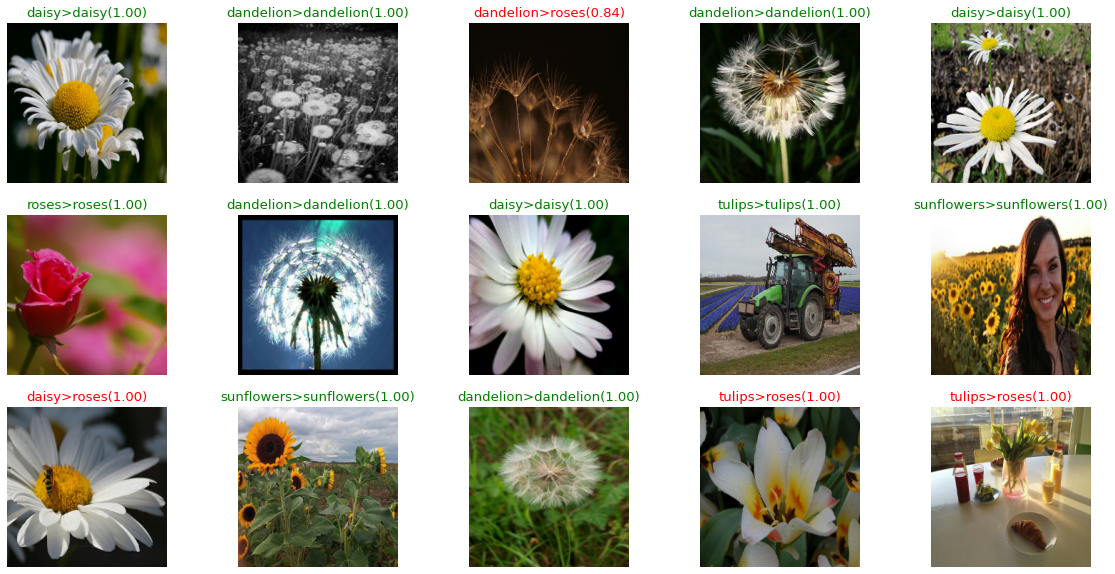

In [48]:
def plot_predictions(filename):
  matplotlib.rcParams.update({'font.size':12})

  dataset = (tf.data.TextLineDataset(filename).map(parse_csv))

  f, ax = plt.subplots(3, 5, figsize=(20, 10))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow(img.numpy())

    batch_pred = model.predict(tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS]))
    pred = batch_pred[0]

    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]    
    label = CLASS_NAMES[label.numpy()]
    if label == pred_label:
      color='green'
    else:
      color='red'

    ax[idx//5, idx%5].set_title('{}>{}({:.2f})'.format(label, pred_label, prob), color=color)
    ax[idx//5, idx%5].axis('off')
plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv")

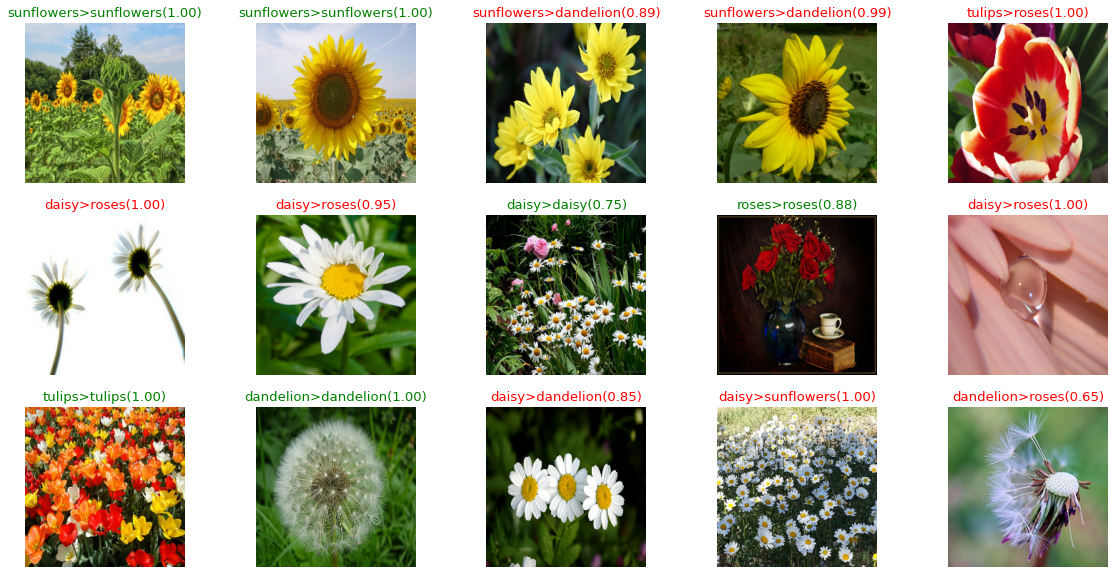

In [49]:
plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv")

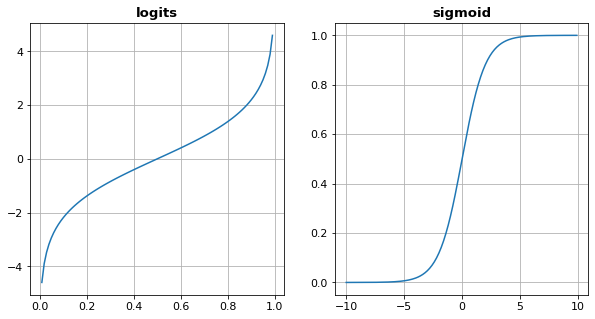

In [123]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))

x = np.arange(0.01, 1.0, 0.01)
y = np.log(x / (1-x))
ax[0].plot(x, y)
ax[0].set_title('logits', fontweight='bold')
ax[0].grid(True)

x = np.arange(-10, 10, 0.1)
y = tf.math.sigmoid(x)
ax[1].plot(x, y)
ax[1].set_title('sigmoid', fontweight='bold')
ax[1].grid(True)

Scaling weights for daisy      in -0.1535 to 0.1189
Scaling weights for dandelion  in -0.1216 to 0.1545
Scaling weights for roses      in -0.1036 to 0.1292
Scaling weights for sunflowers in -0.1651 to 0.1241
Scaling weights for tulips     in -0.1125 to 0.1132


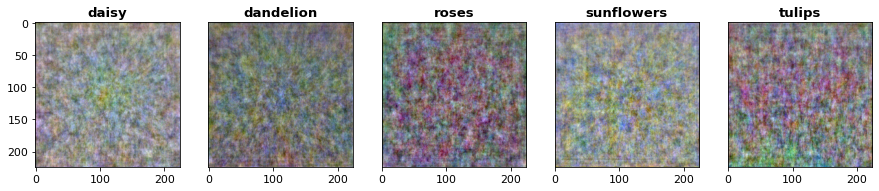

In [122]:
def show_trained_weights(model):
  LAYER=1
  WEIGHT_TYPE=0

  f, ax = plt.subplots(1, 5, figsize=(15, 15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()

    flower_name = CLASS_NAMES[flower]

    print("Scaling weights for {:10} in {:.4f} to {:.4f}".format(flower_name, min_wt, max_wt))

    weights = (weights - min_wt) / (max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3))
    ax[flower].set_title(flower_name, fontweight='bold')    

    if flower > 0:
      ax[flower].yaxis.set_visible(False)

show_trained_weights(model)

In [99]:
model.layers[1].get_weights()[0].shape

(150528, 5)

In [97]:
model.layers[1].get_weights()[0][:, 0] # weights of daisy 

array([-0.01004877, -0.00513377, -0.03482404, ..., -0.02858808,
       -0.03966131,  0.00819248], dtype=float32)

In [96]:
model.layers[1].get_weights()[1] # bias

array([-0.05478864, -0.01836242,  0.01504254,  0.00535573,  0.05407239],
      dtype=float32)

[0.   0.09 0.06 0.85 0.  ] [0.         0.01696592 0.01094963 0.9720845  0.        ]
[0.09090909 0.09090909 0.6363636  0.09090909 0.09090909] [0.04651164 0.04651164 0.8139535  0.04651164 0.04651164]
[0.   0.25 0.5  0.25 0.  ] [0.        0.2       0.6000001 0.2       0.       ]
[0.08333333 0.08333333 0.3333333  0.41666666 0.08333333] [0.06113537 0.06113537 0.33624452 0.48034936 0.06113537]
[0.125 0.125 0.5   0.125 0.125] [0.09090909 0.09090909 0.6363636  0.09090909 0.09090909]


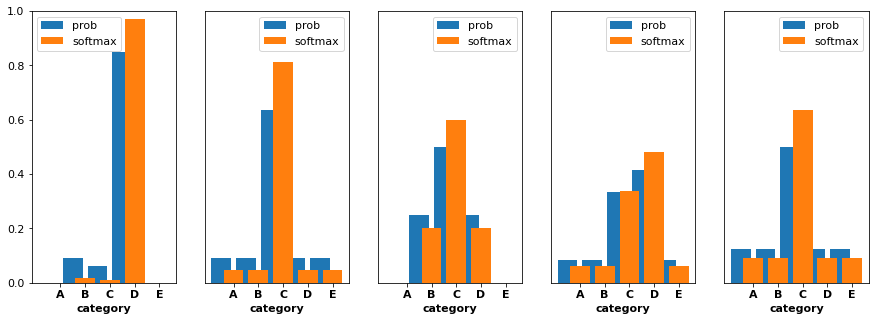

In [114]:
import tensorflow as tf

inx = [
    [0, 0.09, 0.06, 0.85, 0],
    [0.1, 0.1, 0.7, 0.1, 0.1],
    [0, 0.2, 0.4, 0.2, 0],
    [0.1, 0.1, 0.4, 0.5, 0.1],
    [0.2, 0.2, 0.8, 0.2, 0.2],
]

def logit(x):
  return -tf.math.log(1./x-1.)

barWidth = 0.5
r1 = np.arange(len(inx[0]))
r2 = [x + barWidth for x in r1]

f, ax = plt.subplots(1, 5, figsize=(15, 5))
for idx, x in enumerate(inx):
  prob = x / tf.math.reduce_sum(x)
  softmax = tf.nn.softmax(logit(prob))
  print(prob.numpy(), softmax.numpy())

  ax[idx].bar(r1, prob, label='prob')
  ax[idx].bar(r2, softmax, label='softmax')
  ax[idx].legend()
  ax[idx].set_xlabel('category', fontweight='bold')
  ax[idx].set_xticks(r2)
  ax[idx].set_xticklabels(['A','B','C','D','E'], fontweight='bold')  
  ax[idx].set_ylim([0, 1])

  if idx > 0:
    ax[idx].yaxis.set_visible(False)